### This is just an example of how to graph the data provided by the sensor 

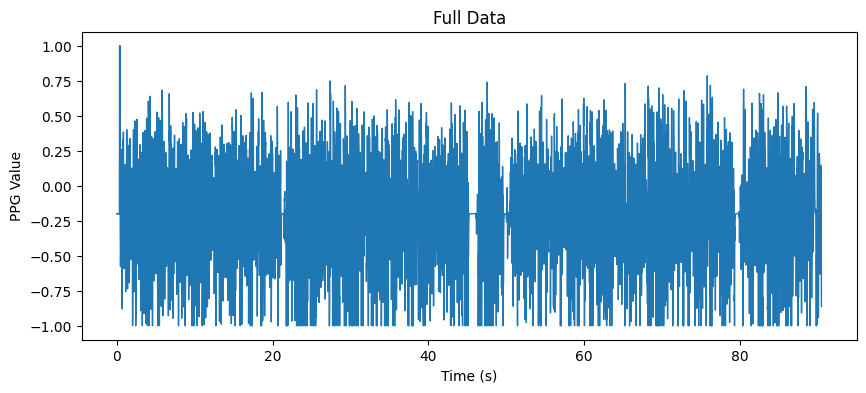

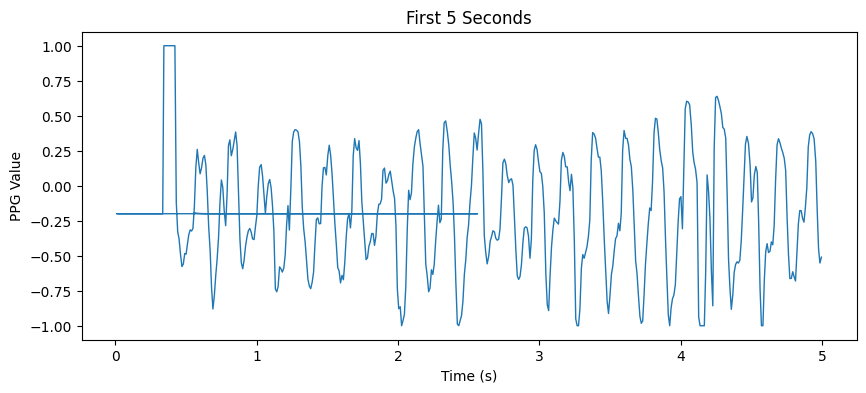

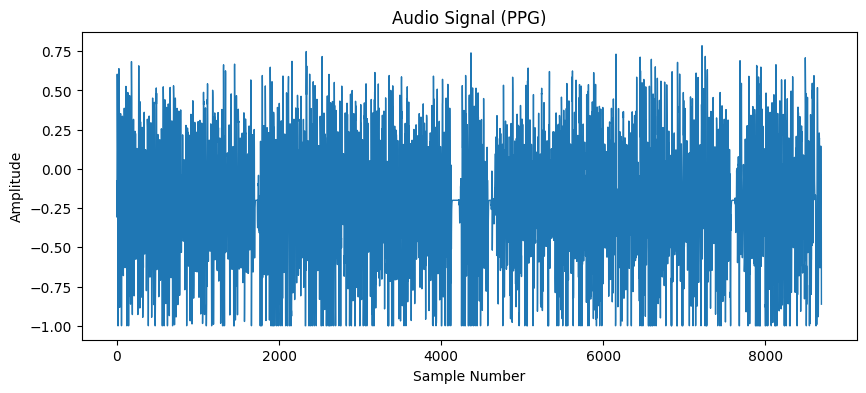

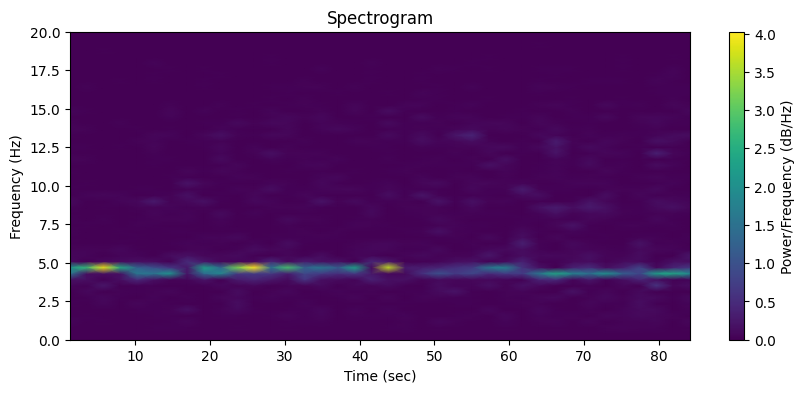

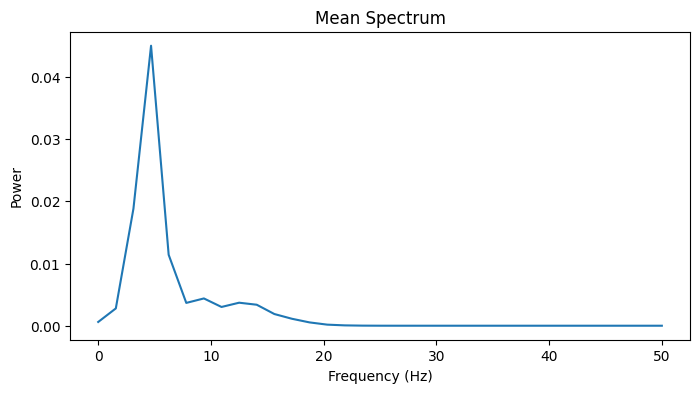

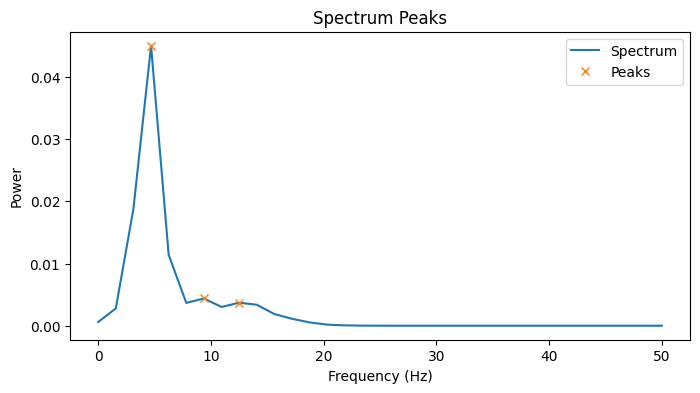

BPM: 281.2


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram, welch, find_peaks

# Load the data
df = pd.read_csv('ppg_data_hummingbird_trial.csv')


# --- Set sampling rate ---
sampling_rate = 100  # Hz

# --- Plot full data ---
plt.figure(figsize=(10, 4))
plt.plot(df['Time (s)'], df['PPG Value'], lw=1)
plt.xlabel("Time (s)")
plt.ylabel("PPG Value")
plt.title("Full Data")
plt.show()

# --- Plot first 5 seconds of data ---
plt.figure(figsize=(10, 4))
mask = (df['Time (s)'] >= 0) & (df['Time (s)'] <= 5)
plt.plot(df.loc[mask, 'Time (s)'], df.loc[mask, 'PPG Value'], lw=1)
plt.xlabel("Time (s)")
plt.ylabel("PPG Value")
plt.title("First 5 Seconds")
plt.show()

# --- Cut duplicated/extra data (keep data after 4 seconds) ---
ppg = df[df['Time (s)'] > 4]

# --- Convert data to audio signal ---
# Here we simply treat the 'PPG Value' column as our signal.
signal = ppg['PPG Value'].values

plt.figure(figsize=(10, 4))
plt.plot(signal, lw=1)
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Audio Signal (PPG)")
plt.show()

# --- Define bandpass filter function ---
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

######## filter for frequencies below 0.5 Hz (30 BPM) or above 20 Hz (1200 BPM)
filtered_signal = bandpass_filter(signal, lowcut=0.5, highcut=20, fs=sampling_rate, order=4)

# spectrogram 


f, t, Sxx = spectrogram(filtered_signal, fs=sampling_rate, nperseg=256)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, 10 * Sxx, shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim(0, 20)  # set frequency axis from 0 to 20 Hz
plt.title("Spectrogram")
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

#for i in range(2,20):
f_welch, Pxx = welch(filtered_signal, fs=sampling_rate, nperseg=64)

plt.figure(figsize=(8, 4))
plt.plot(f_welch, Pxx)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Mean Spectrum")
plt.show()

# --- Identify spectral peaks ---
# Find all peaks in the spectrum.
peaks_indices, _ = find_peaks(Pxx)
peaks_freqs = f_welch[peaks_indices]
peaks_power = Pxx[peaks_indices]

# Get up to 5 highest peaks (if available)
nmax = 5
if len(peaks_power) > 0:
    # Sort peaks by power (descending)
    sorted_indices = np.argsort(peaks_power)[::-1]
    top_n = sorted_indices[:nmax]
    top_peaks_freqs = peaks_freqs[top_n]
    top_peaks_power = peaks_power[top_n]
    
    # Plot the peaks on the spectrum
    plt.figure(figsize=(8, 4))
    plt.plot(f_welch, Pxx, label='Spectrum')
    plt.plot(top_peaks_freqs, top_peaks_power, "x", label='Peaks')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Spectrum Peaks")
    plt.legend()
    plt.show()
    
    # --- Choose the peak with the highest amplitude ---
    idx_max = np.argmax(top_peaks_power)
    hb_freq = top_peaks_freqs[idx_max]  # in Hz
    bpm = hb_freq * 60  # Convert frequency (Hz) to BPM
    print("BPM: {:.1f}".format(bpm))
else:
    print("No peaks found in the spectrum.")
